In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import *
from sklearn.datasets.mldata import fetch_mldata
import tempfile
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn import linear_model as lm
from anytime_regression import *

In [3]:
lam = np.logspace(-5,5,100) 

**Synthetic Experiment** --- **Catogorical Data**

**Data Generation**:                                                                                                    
1) First generate y: randomly pick up 1 or -1.                                                                                
2) Initialize all x1 and x2 with same value of y.                                                                      
3) Randomly flip 10% of x1 and 40% of x2 --- x1 is better feature with 90% accuracy while x2 has 60% accuracy.             
4) Set the probability for each feature to show up at prediction as (0.2 and 0.9)                                      
5) Finished.

Joey: I found your generate_synthetic_data code a bit too complicated for me so I have created a new synthetic dataset generator.  Would be good to know how they differ in the data. (Probably the same?)

```
### Generate Dataset
n = 5000 #number of training data and testing data respectively
d = 2
p = np.array([0.2,0.9]) ## x1 has 90% accuracy and x2 has 60% accuracy
X_train,y_train = generate_synthetic_data(n,d,p)
X_test_o,y_test = generate_synthetic_data(n,d,p)
X_test = modify_data(X_test_o,X_train,p)
X_val,y_val = generate_synthetic_data(n,d,p)
```

In [9]:
#import numpy.matlib
n = 100000
d = 3
propTrain = 0.8
# The probability that the feature will _disagree_ with the label
pError = 0.2 * np.ones(d) # currently all uniform
# Probability of missing a dimension at test time
pMissing = 0.8 * np.ones(d)
# Make first dimension a safe dimension (occurs often)
pMissing[0] = 0.2 

# Construct raw training data
y = np.random.choice([-1., 1.], (n,))
X = np.array([y * np.random.choice([-1., 1.], size=(n,), p=[p, 1. - p]) for p in pError]).T
# Normalize the raw data for simplicity
# X = X - X.mean(axis = 0)
# X = X / X.var(axis = 0)

# Split into training and testing
ind = np.random.permutation(n)
split = int(propTrain * n)
ind_train = ind[:split]
ind_test = ind[split:]
# train and test variables
X_train = X[ind_train, :]
X_test = X[ind_test, :]
y_train = y[ind_train]
y_test = y[ind_test]

# Mask out (set to 0) missing values 
def drop_features(X, pMissing):
    (n,_) = X.shape
    # Adding + 0. to prevent any floating point leakage of sign information (though should not be necessary)
    return X * np.array([np.random.choice([0., 1.], size=(n,), p=[p, 1. - p]) for p in pMissing]).T + 0.

def joey_vanilla_ridge_regression(X, y, lam):
    (n,d) = X.shape
    # solve is numerically more stable (and efficient) than inverse * X' y
    return np.linalg.solve(np.dot(X.T, X) + lam * np.eye(d), np.dot(X.T, y))

def l2error(w, X, y):
    r = np.dot(X, w) - y
    return (r * r).mean()

# Binray prediction error (what fraction of the time was the sign incorrect)
def predError(w, X, y):
    p = np.dot(X, w) + 0.
    return (((y < 0.) & (p > 0.)) | ((y > 0.) & (p < 0.))).mean()

# Test features with missing values
X_test_o = drop_features(X_test, pMissing)

In [6]:
X_test

array([[ 1.,  1.,  1.],
       [ 1., -1., -1.],
       [ 1.,  1., -1.],
       ..., 
       [-1.,  1.,  1.],
       [ 1., -1.,  1.],
       [-1., -1.,  1.]])

vanilla ridge regression

In [104]:
X_test_o.mean(axis=0)

array([  3.78000242e-02,   2.60154886e-03,   4.04000792e-02,
         2.84021006e-02,  -7.60009850e-03,   1.28012294e-02,
         1.16008186e-02,  -3.00004800e-03,  -2.06723527e-16,
         4.48066690e-02])

In [116]:
y_test.mean()

-0.0086

In [15]:
X_test

array([[-1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  1.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [12]:
lopt = 24770.7635599
w = joey_vanilla_ridge_regression(X_train, y_train, lopt)
print w
print "Train:"
print "\tl2 error", l2error(w, X_train, y_train)
print "\tpred error", predError(w, X_train, y_train)
print "Test:"
print "\tl2 error", l2error(w, X_test, y_test)
print "\tpred error", predError(w, X_test, y_test)
print "Test with dropped features:"
print "\tl2 error", l2error(w, X_test_o, y_test)
print "\tpred error", predError(w, X_test_o, y_test)

[ 0.29635276  0.29556857  0.29539412]
Train:
	l2 error 0.384551139697
	pred error 0.1031375
Test:
	l2 error 0.387849283083
	pred error 0.1048
Test with dropped features:
	l2 error 0.706471004007
	pred error 0.17415


In [5]:
def joey_vanilla_ridge_regression(X, y, lam):
    (n,d) = X.shape
    # solve is numerically more stable (and efficient) than inverse * X' y
    return np.linalg.solve(np.dot(X.T, X) + lam * np.eye(d), np.dot(X.T, y))

def l2error(w, X, y):
    r = np.dot(X, w) - y
    return (r * r).mean()

# Binray prediction error (what fraction of the time was the sign incorrect)
def predError(w, X, y):
    p = np.dot(X, w) + 0.
    return (((y < 0.) & (p > 0.)) | ((y > 0.) & (p < 0.))).mean()

In [84]:
test_l2error = []
test_prederror = []
for l in lam:
    w = joey_vanilla_ridge_regression(X_train, y_train, l)
    test_l2error.append(l2error(w, X_test, y_test))
    test_prederror.append(predError(w, X_test, y_test))

In [90]:
print lam[np.argmin(test_prederror)]

24770.7635599


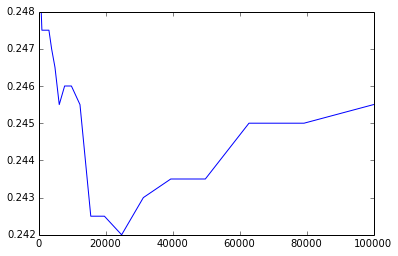

In [85]:
plt.plot(lam, test_prederror)

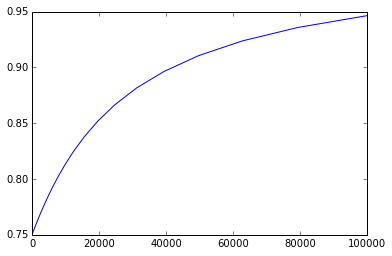

In [64]:
plt.plot(lam,test_l2error)